In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import EfficientNetB5
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle, shutil
import seaborn as sns

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ridolarax","key":"3a371009f6c0ec608d5f4f3e0ed5c7fa"}'}

In [ ]:
mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download kaustubhb999/tomatoleaf

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
 96% 171M/179M [00:01<00:00, 172MB/s]
100% 179M/179M [00:01<00:00, 136MB/s]


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! unzip tomatoleaf.zip

Streaming output truncated to the last 5000 lines.
  inflating: tomato/train/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0044d10f-7062-4655-8abd-9fffc5b2f152___Com.G_TgS_FL 7908.JPG  
  inflating: tomato/train/Tomato___Target_Spot/00854623-ba28-446d-a1d5-03c0ae3f99d9___Com.G_TgS_FL 7949.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118c27a-f34a-41e1-8b2f-d2c564f83c5c___Com.G_TgS_FL 0013.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118ed61-b135-45be-ad81-7e2d54203be4___Com.G_TgS_FL 8241.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0197df47-a9cb-4b6c-b72c-ac0e9af6d135___Com.G_TgS_FL 0779.JPG  
  inflating: tomato/train/Tomato___Target_Spot/025510ac-15db-4861-b02b-21da82161100___Com.G_TgS_FL 0952.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0288164e-d6cf-4215-b593-7b581308a4cf___Com.G_TgS_FL 9777.JPG  
  inflating: tomato/train/Tomato___Target_Spot/03002b91-afe3-4c72-86b

In [ ]:
!ls

kaggle.json  sample_data  tomato  tomatoleaf.zip


In [ ]:
# Structure the dataset

# creating paths
data_dir = '/content/tomato/'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')


In [ ]:
train_dir, validation_dir

('/content/tomato/train', '/content/tomato/val')

In [ ]:
def folder_data(folder, target_size=(150, 150), max_images=None, seed=42):
    """
        Load images from a folder and return their paths and labels.

        Args:
          folder (str): Path to the folder containing the images.
          target_size (tuple): Target size for the resized images.
          max_images (int): Maximum number of images to load.

    """
    classes = sorted(os.listdir(folder))
    X_paths = []
    y = []

    for label, class_name in enumerate(classes):
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            img_files = os.listdir(class_folder)
            img_paths = [os.path.join(class_folder, img_file) for img_file in img_files]
            X_paths.extend(img_paths)
            y.extend([label] * len(img_paths))

    # Convert lists to numpy arrays
    X_paths = np.array(X_paths, dtype='object')
    y = np.array(y, dtype='int')

    # Set a random seed for reproducibility
    np.random.seed(seed)

    # Shuffle the data
    indices = np.arange(X_paths.shape[0])
    np.random.shuffle(indices)
    X_paths = X_paths[indices]
    y = y[indices]

    # Select a subset of the data if max_images is specified
    if max_images is not None:
        X_paths = X_paths[:max_images]
        y = y[:max_images]

    return X_paths, y, classes

def display_images(X_paths, y, class_names, num_images=5):
    """
    Display a few images along with their labels.

    Args:
    - X_paths: Numpy array of image file paths.
    - y: Numpy array of labels.
    - class_names: List of class names.
    - num_images: Number of images to display.
    """
    plt.figure(figsize=(15, 15))
    indices = np.random.choice(len(X_paths), num_images, replace=False)

    for i, idx in enumerate(indices):
        img = Image.open(X_paths[idx])
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(class_names[y[idx]])
        plt.axis("off")
    plt.show()

train_dir = '/content/tomato/train'
validation_dir = '/content/tomato/val'

X_train_paths, y_train, train_classes = folder_data(train_dir, max_images = 2000)
X_val_paths, y_val, val_classes = folder_data(validation_dir)

# Class names are the same for train and validation datasets
class_names = train_classes


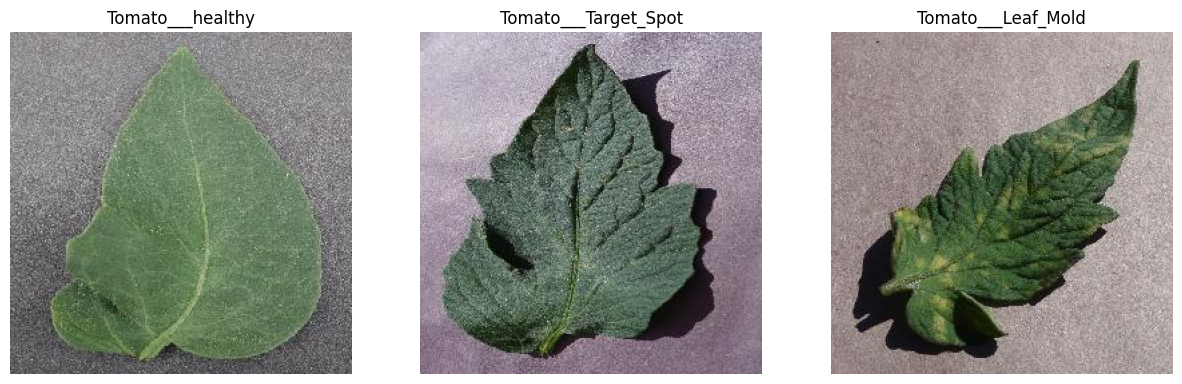

In [ ]:
display_images(X_train_paths, y_train, class_names, num_images=3)

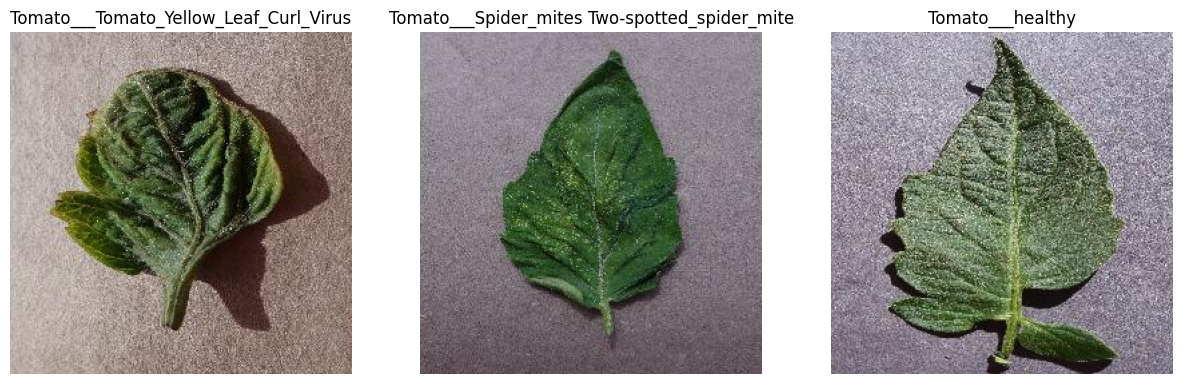

In [ ]:
display_images(X_val_paths, y_val, class_names, num_images=3)

In [ ]:
X_train_paths.shape

(2000,)

In [ ]:
!ls

kaggle.json  sample_data  tomato  tomatoleaf.zip


# **Building the Model: Transfer Learning (EfficientNetB5)**

In [ ]:
# Create a temporary directory for the 2000 images

def create_temp_dir_with_subset(X_paths, y, classes, temp_dir):
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    os.makedirs(temp_dir)

    for class_index, class_name in enumerate(classes):
        class_dir = os.path.join(temp_dir, class_name)
        os.makedirs(class_dir)

    for i, path in enumerate(X_paths):
        label = y[i]
        class_name = classes[label]
        class_dir = os.path.join(temp_dir, class_name)
        shutil.copy(path, class_dir)

# Define a temporary directory to hold the subset of images
temp_train_dir = '/content/temp_tomato_train'

# Create the temporary directory with the subset of images
create_temp_dir_with_subset(X_train_paths, y_train, train_classes, temp_train_dir)


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Define image size and batch size
image_size = (456, 456)
batch_size = 4

# Define the training data generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the validation data generator
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    temp_train_dir,  # Use the temporary directory
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Create the validation data generator
val_generator = val_datagen.flow_from_directory(
    '/content/tomato/val',  # Use the original validation directory
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [ ]:
!ls

kaggle.json  sample_data  temp_tomato_train  tomato  tomatoleaf.zip


In [ ]:
# Building the model

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the EfficientNetB5 model with pretrained weights on ImageNet, excluding the top layers
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(456, 456, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)  # Assuming 10 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

115263384/115263384 [==============================] - 1s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Using Adam optimizer
              loss='categorical_crossentropy',  # Using categorical crossentropy loss
              metrics=['accuracy'])


# Path to save the trained model on google drive
checkpoint_path = '/content/drive/My Drive/checkpoints/best_model.h5'

# Define callbacks for checkpointing and early stopping
checkpoint = ModelCheckpoint(
    checkpoint_path,  # File path to save the best model
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    save_weights_only=False,  # Save the whole model
    mode='min',  # Minimize the monitored metric
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min'
)



In [ ]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=5,
    callbacks=[checkpoint, early_stopping]
)



Epoch 1/5
500/500 [==============================] - ETA: 0s - loss: 1.3655 - accuracy: 0.5515 
Epoch 1: val_loss improved from inf to 0.45732, saving model to /content/drive/My Drive/checkpoints/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 9969s 20s/step - loss: 1.3655 - accuracy: 0.5515 - val_loss: 0.4573 - val_accuracy: 0.8500
Epoch 2/5
500/500 [==============================] - ETA: 0s - loss: 0.5757 - accuracy: 0.8270 
Epoch 2: val_loss improved from 0.45732 to 0.25039, saving model to /content/drive/My Drive/checkpoints/best_model.h5
500/500 [==============================] - 9863s 20s/step - loss: 0.5757 - accuracy: 0.8270 - val_loss: 0.2504 - val_accuracy: 0.9240
Epoch 3/5
500/500 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8775 
Epoch 3: val_loss improved from 0.25039 to 0.20551, saving model to /content/drive/My Drive/checkpoints/best_model.h5
500/500 [==============================] - 9896s 20s/step - loss: 0.3927 - accuracy: 0.8775 - val_loss: 0.2055 - val_accuracy: 0.9310
Epoch 4/5
500/500 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.9115 
Epoch 4: val_loss did not improve from 0.20551
500/500 [==================

In [ ]:
## Continue from where we stopped

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Path to the saved model on google drive
model_path = '/content/drive/My Drive/checkpoints/best_model.h5'



# Load the model
model = tf.keras.models.load_model(model_path)


In [ ]:
y_pred1 = model.predict(val_generator)
print(y_pred1)

250/250 [==============================] - 1163s 5s/step
[[9.99850154e-01 7.89097248e-06 1.76711892e-05 ... 6.49574167e-06
  1.15400574e-07 7.94909283e-06]
 [2.73700301e-02 1.81281175e-02 9.71151739e-02 ... 3.77914822e-03
  3.11011478e-04 6.04613568e-04]
 [1.97011558e-03 7.59857357e-01 2.29115700e-04 ... 1.22841171e-04
  7.38142553e-05 2.96356942e-04]
 ...
 [9.95052397e-01 2.02532377e-04 1.10533007e-03 ... 9.81270568e-06
  4.04412231e-06 1.18166117e-05]
 [1.30568704e-04 1.37904106e-04 2.88366387e-03 ... 7.88066827e-04
  8.84745359e-01 9.98212141e-04]
 [9.58944031e-04 8.84141743e-01 1.27846829e-03 ... 5.93562261e-04
  2.50795693e-03 5.43496688e-04]]


In [ ]:
# Get true labels and predictions
y_true = val_generator.classes
y_pred_classes = np.argmax(y_pred1, axis=1)

# conf_matrix = confusion_matrix(y_true, y_pred_classes)

y_true, y_pred_classes
y_true.shape, y_pred_classes.shape

((1000,), (1000,))

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [ ]:
import numpy as np

# Create a sample array
array = y_pred_classes

# Find unique values and their counts
unique_values, counts = np.unique(array, return_counts=True)

# Calculate frequencies
frequencies = counts / counts.sum()

# Combine unique values and frequencies
value_frequencies = dict(zip(unique_values, frequencies))

print("Value frequencies:")
for value, frequency in value_frequencies.items():
    print(f"{value}: {frequency:.2f}")


Value frequencies:
0: 0.11
1: 0.10
2: 0.11
3: 0.11
4: 0.10
5: 0.10
6: 0.10
7: 0.09
8: 0.10
9: 0.08


In [ ]:
import pandas as pd

# Convert the NumPy array to a Pandas Series
y_pred_series = pd.Series(y_pred_classes)

# Now you can use value_counts()
value_counts = y_pred_series.value_counts()
print(value_counts)

2    113
3    111
0    106
6    103
8    101
4     99
1     98
5     97
7     91
9     81
Name: count, dtype: int64


In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(val_generator)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

250/250 [==============================] - 1080s 4s/step - loss: 0.2055 - accuracy: 0.9310
Test loss: 0.20551441609859467
Test accuracy: 0.9309999942779541


In [ ]:
# Evaluate the model on the test data #####!!!!
loss, accuracy = model.evaluate(val_generator)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

250/250 [==============================] - 1085s 4s/step - loss: 0.2055 - accuracy: 0.9310
Test loss: 0.20551441609859467
Test accuracy: 0.9309999942779541


## **Testing on Individual Data**









In [ ]:
# Test on an individual data

from tensorflow.keras.preprocessing import image

img_path = '/content/tomato/val/Tomato___Early_blight/00c5c908-fc25-4710-a109-db143da23112___RS_Erly.B 7778.JPG'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(456, 456))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 6s 6s/step
Predicted class: [1]


In [ ]:
class_indices = val_generator.class_indices
print(class_indices)


{'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Spider_mites Two-spotted_spider_mite': 5, 'Tomato___Target_Spot': 6, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Tomato___healthy': 9}


In [ ]:
class_names = {}

for key, value in class_indices.items():
    class_names[value] = key[9:]

print(class_names)


{0: 'Bacterial_spot', 1: 'Early_blight', 2: 'Late_blight', 3: 'Leaf_Mold', 4: 'Septoria_leaf_spot', 5: 'Spider_mites Two-spotted_spider_mite', 6: 'Target_Spot', 7: 'Tomato_Yellow_Leaf_Curl_Virus', 8: 'Tomato_mosaic_virus', 9: 'healthy'}


In [ ]:
# Define the path to an individual test image
img_path = '/content/tomato/val/Tomato___healthy/000bf685-b305-408b-91f4-37030f8e62db___GH_HL Leaf 308.1.JPG'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(456, 456))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make a prediction
predictions = model.predict(img_array)
predicted_class_idx = np.argmax(predictions, axis=1)[0]
predicted_class_name = class_names[predicted_class_idx]

print(f'Predicted class: {predicted_class_name}')

1/1 [==============================] - 1s 1s/step
Predicted class: healthy


In [ ]:
# Get true labels and predictions
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)




250/250 [==============================] - 1293s 5s/step


Accuracy: 0.109


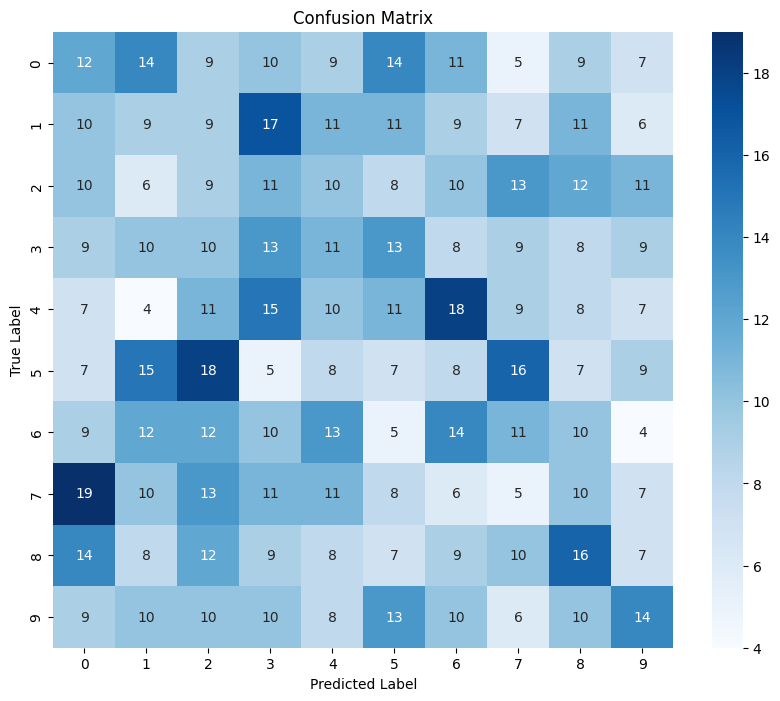

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Generate classification report
class_report = classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys())
print('Classification Report:')
print(class_report)

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.08      0.09      0.09       100
                        Tomato___Early_blight       0.10      0.10      0.10       100
                         Tomato___Late_blight       0.14      0.16      0.15       100
                           Tomato___Leaf_Mold       0.11      0.12      0.11       100
                  Tomato___Septoria_leaf_spot       0.06      0.06      0.06       100
Tomato___Spider_mites Two-spotted_spider_mite       0.07      0.07      0.07       100
                         Tomato___Target_Spot       0.07      0.07      0.07       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.09      0.08      0.08       100
                 Tomato___Tomato_mosaic_virus       0.12      0.12      0.12       100
                             Tomato___healthy       0.06      0.05      0.06       100

                  

## **Continue Training the Model**



In [ ]:
def folder_data2(folder, target_size=(150, 150), max_images=None, seed=42):
    """
        Load images from a folder and return their paths and labels.

        Args:
          folder (str): Path to the folder containing the images.
          target_size (tuple): Target size for the resized images.
          max_images (int): Maximum number of images to load.

    """
    classes = sorted(os.listdir(folder))
    X_paths = []
    y = []

    for label, class_name in enumerate(classes):
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            img_files = os.listdir(class_folder)
            img_paths = [os.path.join(class_folder, img_file) for img_file in img_files]
            X_paths.extend(img_paths)
            y.extend([label] * len(img_paths))

    # Convert lists to numpy arrays
    X_paths = np.array(X_paths, dtype='object')
    y = np.array(y, dtype='int')

    # Set a random seed for reproducibility
    np.random.seed(seed)

    # Shuffle the data
    indices = np.arange(X_paths.shape[0])
    np.random.shuffle(indices)
    X_paths = X_paths[indices]
    y = y[indices]

    # Select a subset of the data if max_images is specified
    if max_images is not None:
        X_paths = X_paths[max_images: max_images + 2000]
        y = y[max_images:max_images+2000]

    return X_paths, y, classes

train_dir = '/content/tomato/train'
validation_dir = '/content/tomato/val'

X_train_paths2, y_train2, train_classes2 = folder_data2(train_dir, max_images = 2000)
X_val_paths2, y_val2, val_classes2 = folder_data2(validation_dir)

# Class names are the same for train and validation datasets
class_names = train_classes


In [ ]:
X_train_paths2.shape, y_train2.shape, train_classes2, temp_train_dir

((2000,),
 (2000,),
 ['Tomato___Bacterial_spot',
  'Tomato___Early_blight',
  'Tomato___Late_blight',
  'Tomato___Leaf_Mold',
  'Tomato___Septoria_leaf_spot',
  'Tomato___Spider_mites Two-spotted_spider_mite',
  'Tomato___Target_Spot',
  'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato___Tomato_mosaic_virus',
  'Tomato___healthy'],
 '/content/temp_tomato_train')

In [ ]:
temp_train_dir2 = '/content/temp_tomato_train2'
create_temp_dir_with_subset(X_train_paths2, y_train2, train_classes2, temp_train_dir2)


In [ ]:
# Create the new train data generator
train_generator2 = train_datagen.flow_from_directory(
    temp_train_dir2,
    target_size=image_size,
    batch_size=4,
    class_mode='categorical'
)

Found 2000 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import json

model2 = tf.keras.models.load_model("/content/drive/MyDrive/checkpoints/best_model.h5")

# Define callbacks
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/model_checkpoints/updated_EfficientNetModel.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto'
)

class SaveHistory(Callback):
    def __init__(self, save_path):
        self.save_path = save_path
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        with open(self.save_path, 'w') as f:
            json.dump(self.history, f)

save_history = SaveHistory("/content/drive/MyDrive/model_checkpoints/training_history_updated.json")



In [ ]:
# Continue training the model with new data ///////njknlkjnlkjbjkbkjvkkhjgchgxtfxhghggcjgcjhg

history = model2.fit(
    train_generator2,
    steps_per_epoch=train_generator2.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=5,
    callbacks=[checkpoint_callback, early_stopping_callback, save_history]
)

Epoch 1/5
500/500 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.8840 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 10765s 21s/step - loss: 0.3651 - accuracy: 0.8840 - val_loss: 0.1731 - val_accuracy: 0.9450
Epoch 2/5
500/500 [==============================] - 10601s 21s/step - loss: 0.2403 - accuracy: 0.9325 - val_loss: 0.1154 - val_accuracy: 0.9680
Epoch 3/5
122/500 [======>.......................] - ETA: 2:17:20 - loss: 0.1929 - accuracy: 0.9385

## **Testing the updated model: The Real Deal**

In [ ]:
final_model = load_model('/content/drive/MyDrive/model_checkpoints/updated_EfficientNetModel.h5')

In [ ]:
class_indices = val_generator.class_indices
class_names = {}

for key, value in class_indices.items():
    class_names[value] = key[9:]

print(class_names)

{0: 'Bacterial_spot', 1: 'Early_blight', 2: 'Late_blight', 3: 'Leaf_Mold', 4: 'Septoria_leaf_spot', 5: 'Spider_mites Two-spotted_spider_mite', 6: 'Target_Spot', 7: 'Tomato_Yellow_Leaf_Curl_Virus', 8: 'Tomato_mosaic_virus', 9: 'healthy'}


In [ ]:
# Evaluate the Updated model on the test data
loss, accuracy = final_model.evaluate(val_generator)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

250/250 [==============================] - 1153s 5s/step - loss: 0.1154 - accuracy: 0.9680
Test loss: 0.11536789685487747
Test accuracy: 0.9679999947547913


In [ ]:
# Get true labels and predictions
y_true = val_generator.classes
y_pred = final_model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)


250/250 [==============================] - 1207s 5s/step


In [ ]:
report = classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys())
print(report)

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.12      0.12      0.12       100
                        Tomato___Early_blight       0.08      0.09      0.09       100
                         Tomato___Late_blight       0.08      0.08      0.08       100
                           Tomato___Leaf_Mold       0.12      0.13      0.12       100
                  Tomato___Septoria_leaf_spot       0.10      0.10      0.10       100
Tomato___Spider_mites Two-spotted_spider_mite       0.07      0.07      0.07       100
                         Tomato___Target_Spot       0.14      0.13      0.13       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.05      0.05      0.05       100
                 Tomato___Tomato_mosaic_virus       0.16      0.16      0.16       100
                             Tomato___healthy       0.17      0.16      0.16       100

                                     accu

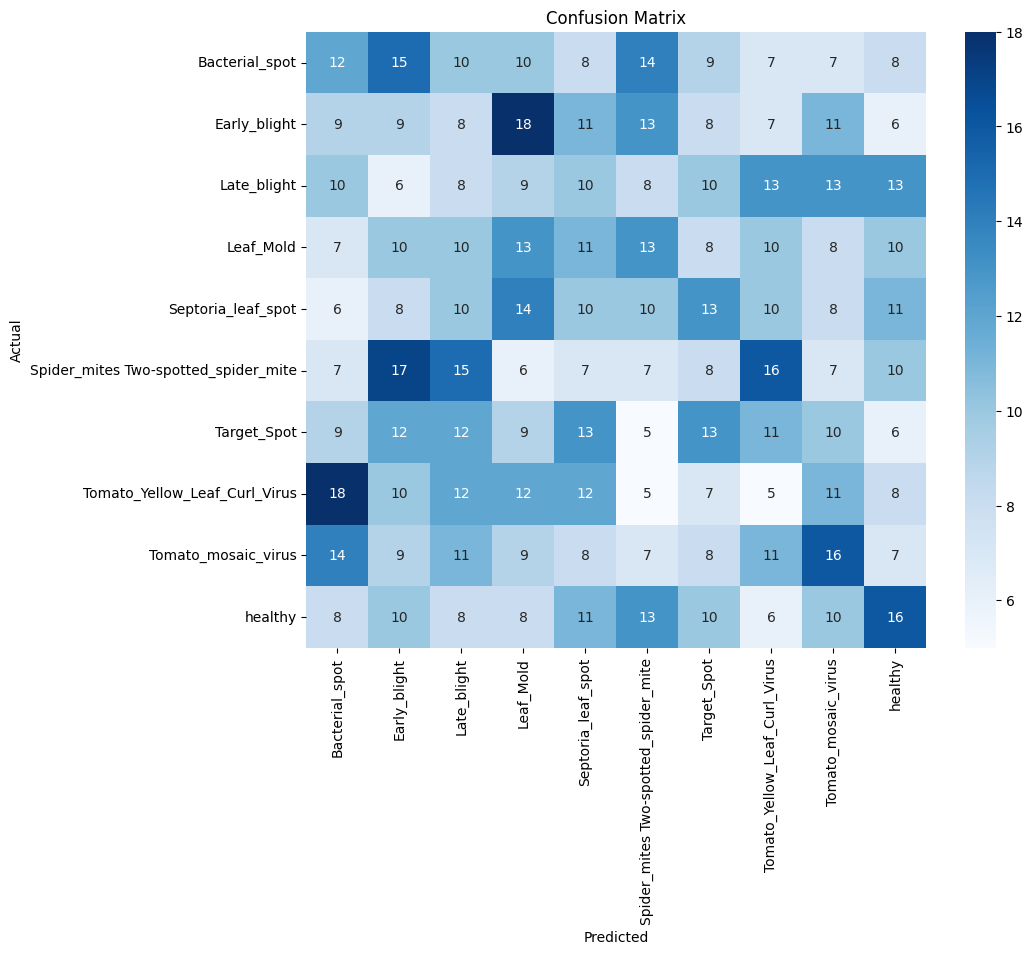

In [ ]:
# Confusion Matrix

class_names = list(train_generator.class_indices.keys())
class_names = [name[9:] for name in class_names]

conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import json

# Load training history from file
with open("/content/drive/MyDrive/model_checkpoints/training_history_updated.json", 'r') as f:
    history = json.load(f)


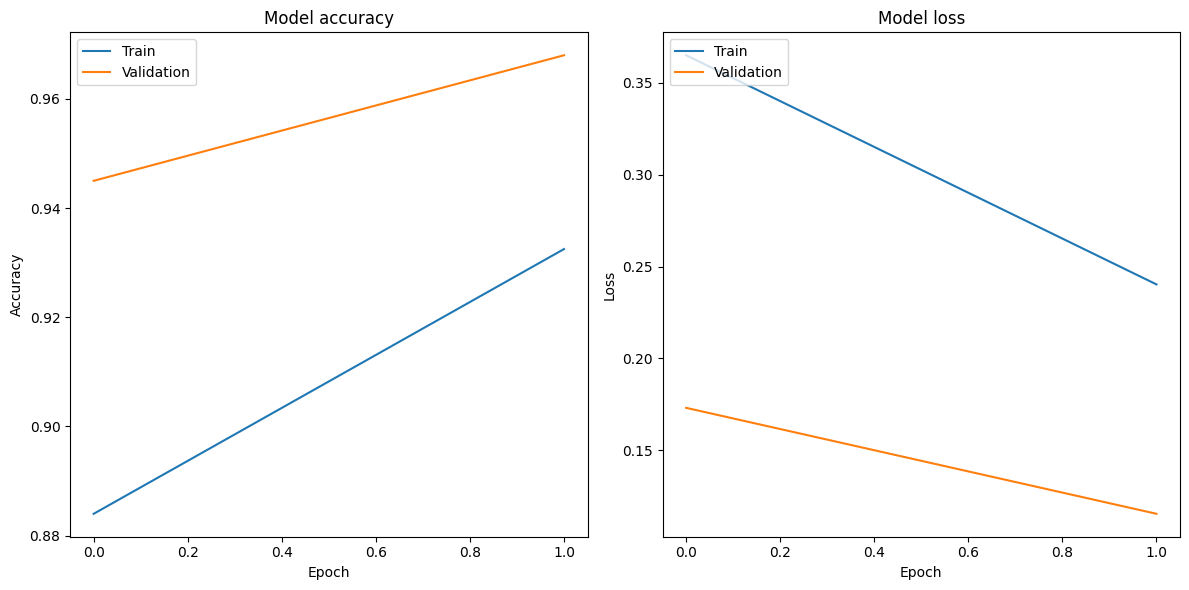

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
